# Importing Library

In [5]:
import torch
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, random_split

# Load the dataset

In [6]:
training_data = datasets.CIFAR10('cifar10train_data', train=True, download=True, transform=None)

testing_data = datasets.CIFAR10('cifar10test_data', train=False, download=True, transform=None)

Files already downloaded and verified
Files already downloaded and verified


## List of classes

In [7]:
training_data.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [8]:
len(training_data)

50000

In [9]:
len(testing_data)

10000

# Sample images from dataset

In [10]:
first_sample, first_label = training_data[0]

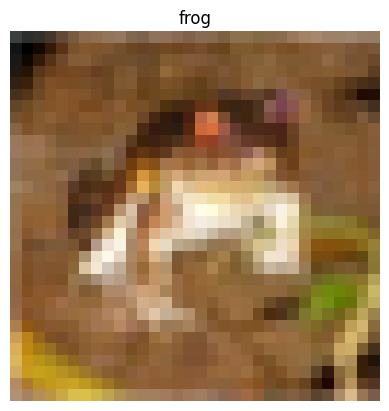

In [11]:
plt.imshow(np.array(first_sample))
plt.title(training_data.classes[first_label])
plt.axis('off')
plt.show()

In [12]:
second_sample, second_label = training_data[9]

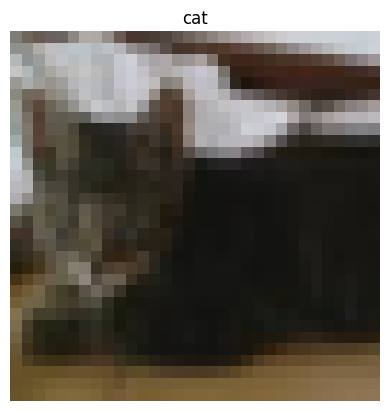

In [13]:
plt.imshow(np.array(second_sample))
plt.title(training_data.classes[second_label])
plt.axis('off')
plt.show()

# Splitting the dataset into training, validation and testing set

Originally, there were 50000 training data 10000 testing data
the ratio is 83.33% for training data and 16.67% for testing data

The training data will be further split into training data and validation data, where the data split would be:

Training data = 40000 (66.67%)

Validation data = 10000 (16.67%)

Testing data = 10000 (16.67%)

In [14]:
train_size = int(0.8 * len(training_data))
val_size = len(training_data) - train_size 

In [15]:
train_dataset, val_dataset = random_split(training_data, [train_size, val_size])

In [16]:
print("Training data count: ",len(train_dataset))
print("Validation data count: ",len(val_dataset))
print("Testing data count: ",len(testing_data))

Training data count:  40000
Validation data count:  10000
Testing data count:  10000


## Function for resize, normalization and data augmentation

Resize the image to (224,224) to match the pretrained Alexnet input size

Normalize the images to range [0,1] and further normalize using the images mean and standard deviaton

Also apply to data augmentation so that the model can generalize well

Without data augmentation (for testing and validation)

In [17]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),    
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

With data augmentation (for training)

In [18]:
augment_transform = transforms.Compose([
    transforms.Resize((224, 224)),

    #Data augmentation
    transforms.RandomRotation(degrees=20),            
    transforms.RandomAffine(degrees=0, translate=(0.14, 0.14)),  
    transforms.RandomHorizontalFlip(p=0.5),           
    transforms.RandomResizedCrop(size=224, scale=(1 - 0.11, 1 + 0.11)), 
    transforms.ColorJitter(brightness=(0.9, 1.1)),    
    transforms.RandomAffine(degrees=0, shear=0.12),   
    transforms.Lambda(lambda img: transforms.functional.adjust_gamma(img, 1 + 0.1 * (2 * torch.rand(1).item() - 1))),

    
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

## Resize and normalize the training , validation and testing images

Augment the data inside training set

In [19]:
train_dataset.dataset = datasets.CIFAR10('cifar10train_data', transform=augment_transform)

val_dataset.dataset = datasets.CIFAR10('cifar10train_data', transform=transform)

testing_data = datasets.CIFAR10('cifar10test_data', train=False, download=True, transform=transform)

Files already downloaded and verified


# Divide the data into batches

In [20]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(testing_data, batch_size=32, shuffle=False)

# Building the model

## Load the Alexnet

In [21]:
alexnet = models.alexnet(pretrained=True)

Alexnet architecture and parameters

In [22]:
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

## Tweaking the Alexnet parameter

In [23]:
alexnet.classifier[6] = torch.nn.Linear(4096, len(training_data.classes))

In [26]:
(alexnet, (3, 224, 224))

(AlexNet(
   (features): Sequential(
     (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
     (1): ReLU(inplace=True)
     (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
     (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
     (4): ReLU(inplace=True)
     (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
     (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (7): ReLU(inplace=True)
     (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (9): ReLU(inplace=True)
     (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (11): ReLU(inplace=True)
     (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
   (classifier): Sequential(
     (0): Dropout(p=0.5, inplace=False)
     (1): Linear(in_features=9216, out_feature

## Setting up the hyperparameter

In [21]:
optimizer_adam = torch.optim.Adam(alexnet.parameters(), lr=2e-5)
loss_function_crossentropy = torch.nn.CrossEntropyLoss()

## Function to train the model

In [22]:
def trainModel(model,loss_function,optimizer,epochs,device):
    history = []
    higest_accuracy = 0

    for epoch in range(epochs):
        print(f"Epoch: {epoch+1}/{epochs}",flush=True)

        model.train()

        train_loss = 0.0
        train_acc = 0.0

        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)

            loss = loss_function(outputs, labels)

            loss.backward()

            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

            _, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            train_acc += acc.item() * inputs.size(0)
    
    
        valid_loss = 0.0
        valid_acc = 0.0


        with torch.no_grad():

            model.eval()

            for j, (inputs, labels) in enumerate(val_loader):
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)

                loss = loss_function(outputs, labels)

                valid_loss += loss.item() * inputs.size(0)

                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                valid_acc += acc.item() * inputs.size(0)
        
        avg_train_loss = train_loss/len(train_dataset)
        avg_train_acc = train_acc/len(train_dataset)

        avg_valid_loss = valid_loss/len(val_dataset)
        avg_valid_acc = valid_acc/len(val_dataset)

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])

        print(f"Epoch : {epoch+1} Training Loss: {avg_train_loss:.4f}, Training Accuracy: {avg_train_acc:.4f}",flush=True)
        print(f"Validation Loss: {avg_valid_loss:.4f}, Validation Accuracy: {avg_valid_acc:.4f}",flush=True)
    
    return model, history

In [23]:
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alexnet.to(device)
trained_model, history = trainModel(alexnet, loss_function_crossentropy, optimizer_adam, num_epochs,device)

Epoch: 1/10
Epoch : 1 Training Loss: 0.9131, Training Accuracy: 0.6748
Validation Loss: 0.5292, Validation Accuracy: 0.8225
Epoch: 2/10
Epoch : 2 Training Loss: 0.5920, Training Accuracy: 0.7940
Validation Loss: 0.4269, Validation Accuracy: 0.8562
Epoch: 3/10
Epoch : 3 Training Loss: 0.5036, Training Accuracy: 0.8220
Validation Loss: 0.3962, Validation Accuracy: 0.8649
Epoch: 4/10
Epoch : 4 Training Loss: 0.4491, Training Accuracy: 0.8427
Validation Loss: 0.3632, Validation Accuracy: 0.8768
Epoch: 5/10
Epoch : 5 Training Loss: 0.4075, Training Accuracy: 0.8573
Validation Loss: 0.3664, Validation Accuracy: 0.8774
Epoch: 6/10
Epoch : 6 Training Loss: 0.3751, Training Accuracy: 0.8683
Validation Loss: 0.3388, Validation Accuracy: 0.8861
Epoch: 7/10
Epoch : 7 Training Loss: 0.3515, Training Accuracy: 0.8762
Validation Loss: 0.3162, Validation Accuracy: 0.8945
Epoch: 8/10
Epoch : 8 Training Loss: 0.3295, Training Accuracy: 0.8846
Validation Loss: 0.3446, Validation Accuracy: 0.8900
Epoch: 9

Save the model

In [24]:
torch.save(trained_model.state_dict(), 'alexnet_cifar10.pth')

Convert history to numpy array and adjusting epoch value for plotting

In [25]:
array_history = np.array(history)

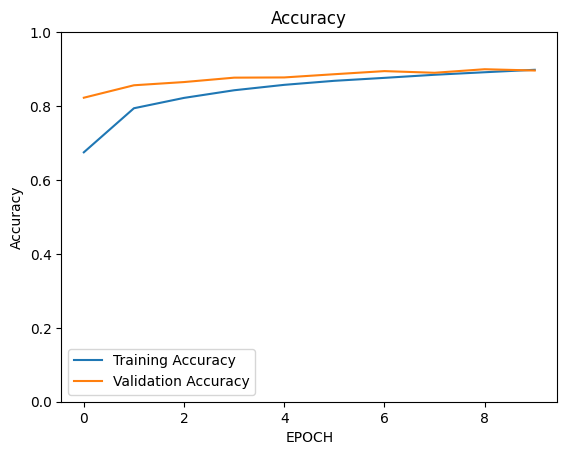

In [26]:
plt.plot(array_history[:, 2], label='Training Accuracy')
plt.plot(array_history[:, 3], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('EPOCH')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.show()

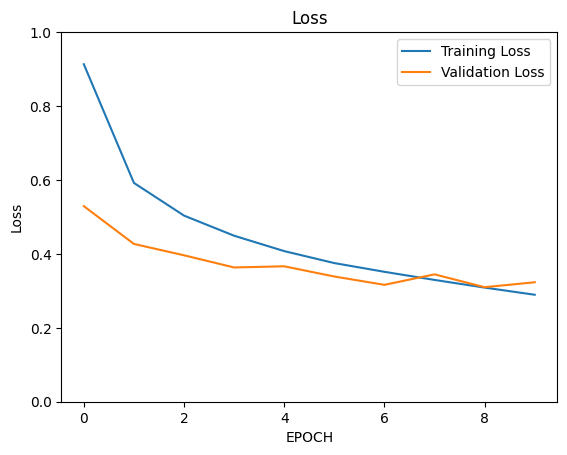

In [27]:
plt.plot(array_history[:, 0], label='Training Loss')
plt.plot(array_history[:, 1], label='Validation Loss')
plt.title('Loss')
plt.xlabel('EPOCH')
plt.ylabel('Loss')
plt.ylim(0, 1)
plt.legend()
plt.show()

## Function for evaluating model

In [55]:
def evaluate_model(model, test_loader, device):
    model.to(device)  
    test_loss = 0.0
    test_acc = 0.0
    total_samples = 0

    with torch.no_grad():  
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)  
            loss = loss_function_crossentropy(outputs, labels)  

            test_loss += loss.item() * inputs.size(0)

            # Calculate accuracy
            _, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            test_acc += correct_counts.sum().item()  
            total_samples += labels.size(0) 

    avg_test_loss = test_loss / total_samples
    avg_test_acc = test_acc / total_samples

    return avg_test_loss, avg_test_acc

In [87]:
loss, accuracy = evaluate_model(trained_model, test_loader, device)

In [88]:
print(f"Loss: {loss:.4f}")

Loss: 0.3274


In [89]:
print(f"Test Accuracy: {accuracy*100:.2f}%")

Test Accuracy: 89.32%
